In [2]:
library(foreign)
library(ggplot2)
library(AER)
library(haven)
library(sandwich)
library(lmtest)
library(formattable)
library(ggplot2)
library(dplyr)

This problem set is based on the article, “Nation Building Through Foreign Intervention: Evidence from
Discontinuities in Military Strategies” (Dell and Querubin, 2018) https://scholar.harvard.edu/dell/publications/nation-building-through-foreign-intervention-evidence-discontinuities-military. Use the article and data
provided to answer the questions below.

## Exercise 1.  Balance
For this exercise, use partial regression and adjust for latitude, longitude, and the segment.

### a) Report a balance table for villages in the dataset in the Marine Corps and Army-controlled regions. Consider elevation, slope, the presence of a factory, the presence of a market and the total colonial roads. Comment on balance.

1. Reading file with data

In [3]:
data_file = 'marines_hamlet_clean.dta'
ps3_data = read_dta(data_file)

2. Checking for balance on independent variables in both groups: those villages under Army and those under USMC

In [15]:
# Balance before adjusting for latitude,longitude, and the segment

# Doing regressions using elev, slope, factory, market, colonial_roads as dependent variables, 
# and treat as independent variables (1= being in a USMC region, 0=being in an Army region)
reg_pre = lapply(select(ps3_data, elev, slope, factory, market, colonial_roads), function(x) lm(x ~ treat, data=ps3_data))
# Creating a data frame with the instercepts and p values for each regression, this will be the balance table
bal_pre = data.frame(t(sapply(reg_pre, function(x) coeftest(x)[c(1, 7)])))
colnames(bal_pre) = c("Intercept", 'P-Value')
bal_pre

,Intercept,P-Value
elev,461.82352941,1.197739e-40
slope,4.05651067,1.666967e-31
factory,0.01604278,2.774587e-02
market,0.04278075,2.960724e-04
colonial_roads,0.42073542,1.141310e-05


We observe that the differences among regions are significant, so, the variables are not balanced in both regions

In [5]:
# Balance after adjusting for latitude,longitude, and the segment

# Doing regressions using elev, slope, factory, market, colonial_roads as dependent variables, 
# adjusting by lattitud, longitud and segment.
p_regs = lapply(select(ps3_data, elev, slope, factory, market, colonial_roads), function(x) lm(x~ lat + lon + seg2, data=ps3_data))
#getting the residuals, this is the effect after doing the regressions on lattitud, longitud and segment
residuals = data.frame(lapply(p_regs, function(x) residuals(x)))
# Doing regressions using elev, slope, factory, market, colonial_roads as dependent variables, 
# and treat as independent variables (1= being in a USMC region, 0=being in an Army region)
regs_adj = lapply(residuals, function(x) lm(x ~ treat, data=ps3_data))
# Creating a data frame with the instercepts and p values for each regression, this will be the balance table
bal_adj = data.frame(t(sapply(regs_adj, function(x) coeftest(x)[c(1, 7)])))
colnames(bal_adj) = c("Intercept", 'P-Value')
bal_adj

,Intercept,P-Value
elev,5.561416321,0.7192257
slope,0.099501675,0.6891926
factory,0.001490953,0.8362539
market,0.005706957,0.6205349
colonial_roads,0.040100387,0.6474547


After controling by latitud, longitud and segment, the variables are balanced in both regions

### b) Now use plots where the running variable is the distance to the regional divide and examine trends for elevation, slope, and total colonial roads on both sides of the discontinuity. Comment on anything gleaned from the trends.

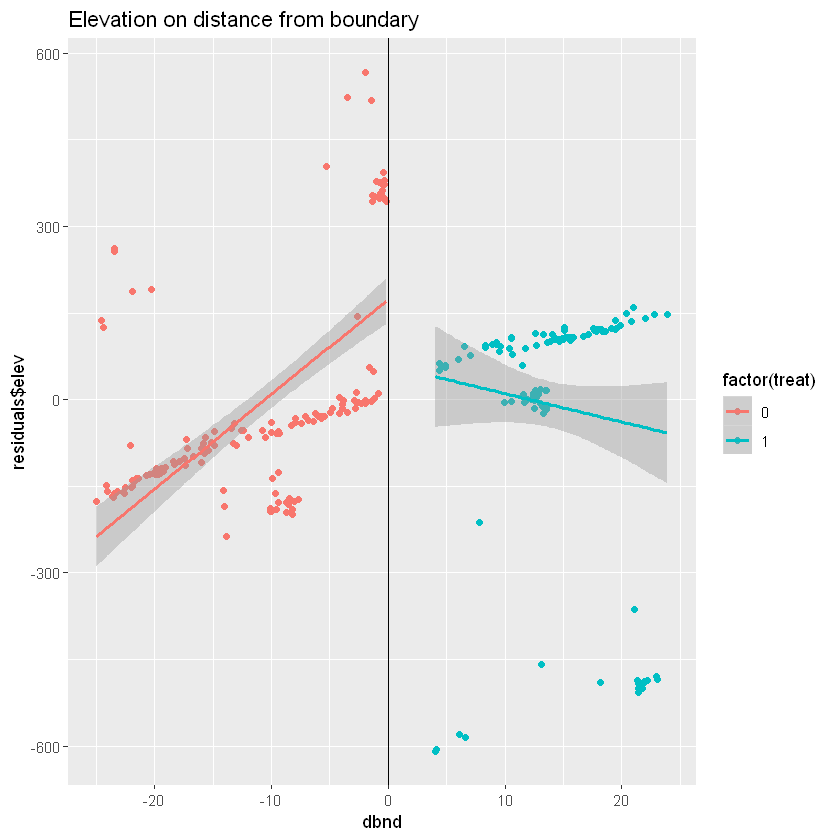

In [6]:
ggplot(ps3_data, aes(x = dbnd, y = residuals$elev, color=factor(treat)))+ 
geom_point() +
stat_smooth(method = lm) +
geom_vline(xintercept = 0)+
ggtitle("Elevation on distance from boundary")

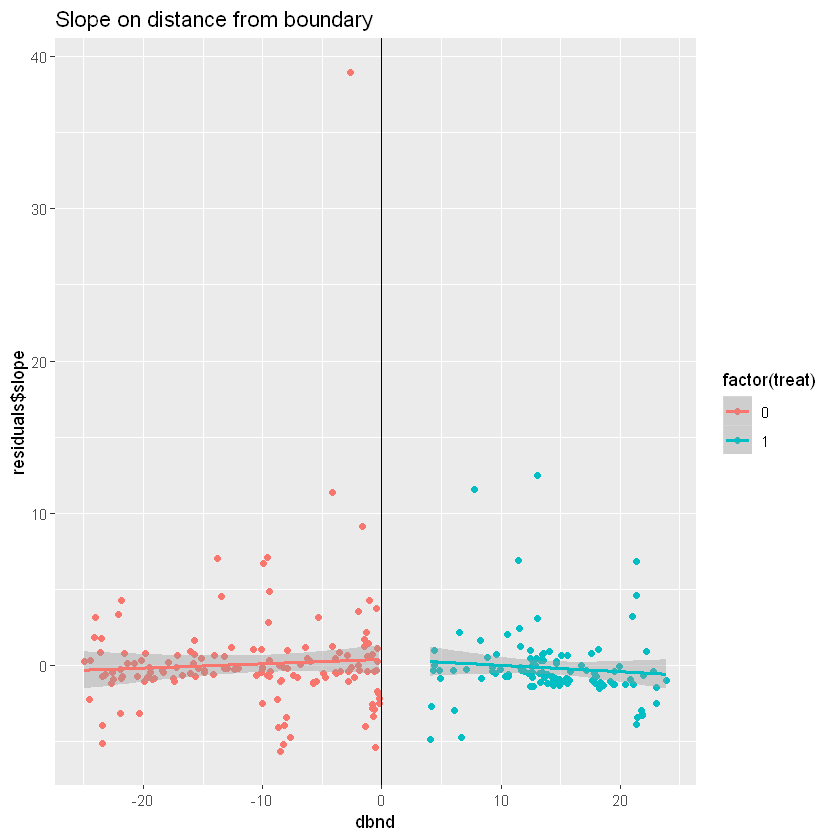

In [7]:
ggplot(ps3_data, aes(x = dbnd, y = residuals$slope, color=factor(treat)))+ 
  geom_point() +
  stat_smooth(method = lm) +
  geom_vline(xintercept = 0)+
  ggtitle("Slope on distance from boundary")

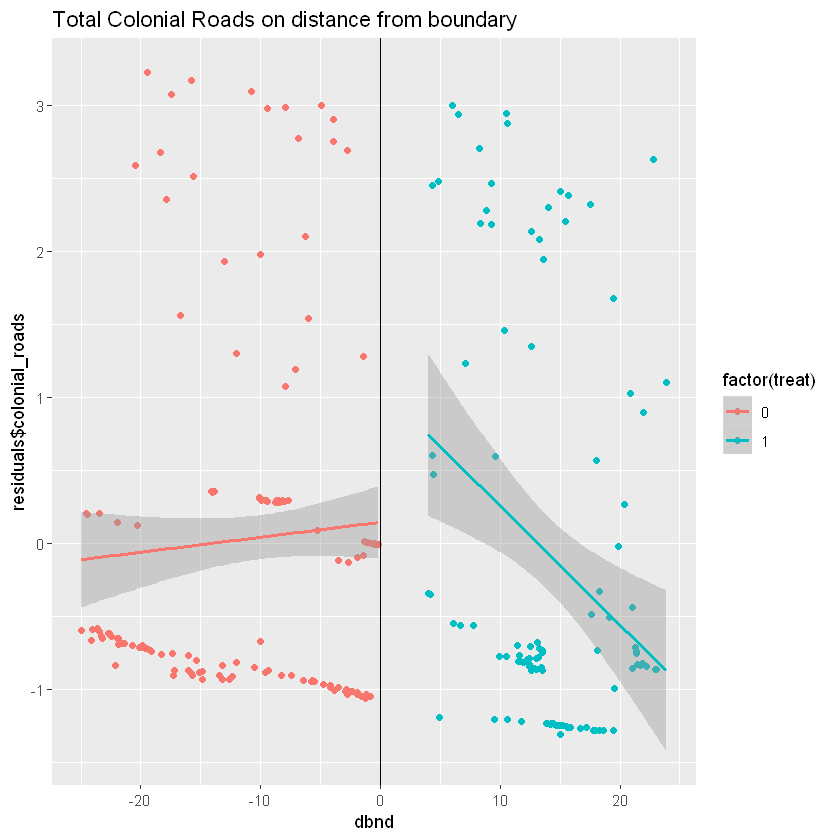

In [8]:
ggplot(ps3_data, aes(x = dbnd, y = residuals$colonial_roads, color=factor(treat)))+ 
  geom_point() +
  stat_smooth(method = lm) +
  geom_vline(xintercept = 0)+
  ggtitle("Total Colonial Roads on distance from boundary")

# Excersice 2. Examining the Effect at the Discontinuity

### a) For 3 outcome variables the Posteriors on Education, Health and Security, make 3 plots. Each plot should have the running variable along the x axis and the outcome along the y axis, the discontinuity at zero, and separate scatter plots, regression lines and 95% confidence intervals on either side of the discontinuity. Use partial regression and adjust for latitude, longitude, elevation, slope and the segment. Do you observe an effect of the hearts and minds approach for these outcomes? Comment and interpret.

In [9]:
# Doing regressions using health_p1, educ_p1, sec_p1 as dependent variables and lat + lon + elev+ slope+ seg2 as independent variables
outcomes_regs = lapply(select(ps3_data, health_p1, educ_p1, sec_p1), function(x) lm(x ~ lat + lon + elev+ slope+ seg2, data=ps3_data))
res_outcomes = data.frame(lapply(outcomes_regs, function(x) residuals(x)))

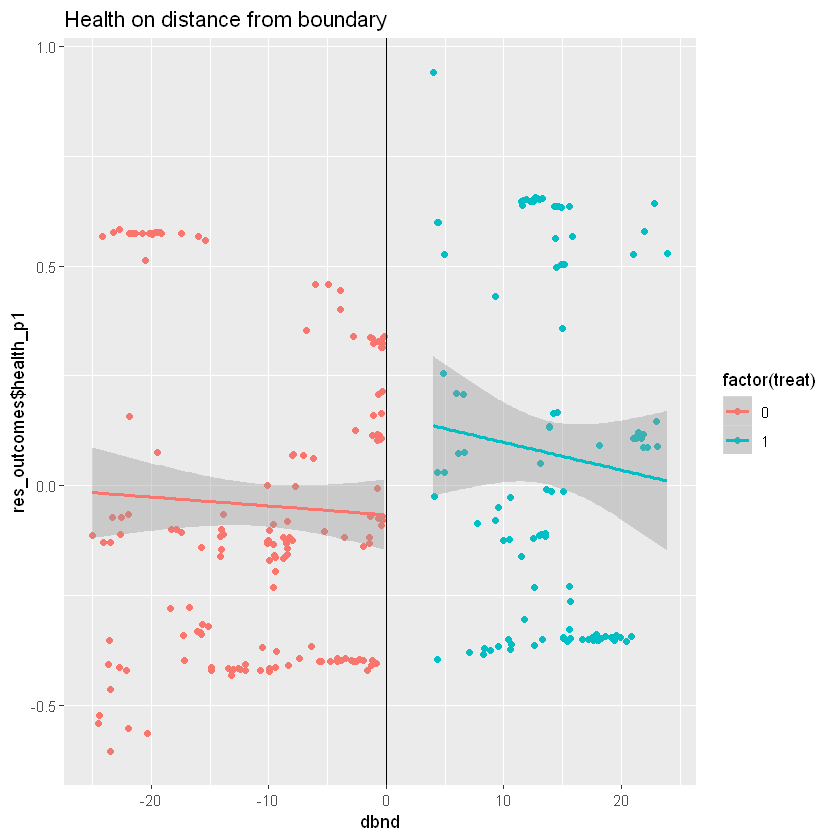

In [10]:
ggplot(ps3_data, aes(x = dbnd, y = res_outcomes$health_p1, color=factor(treat)))+ 
  geom_point() +
  stat_smooth(method = lm) +
  geom_vline(xintercept = 0) +
  ggtitle("Health on distance from boundary")

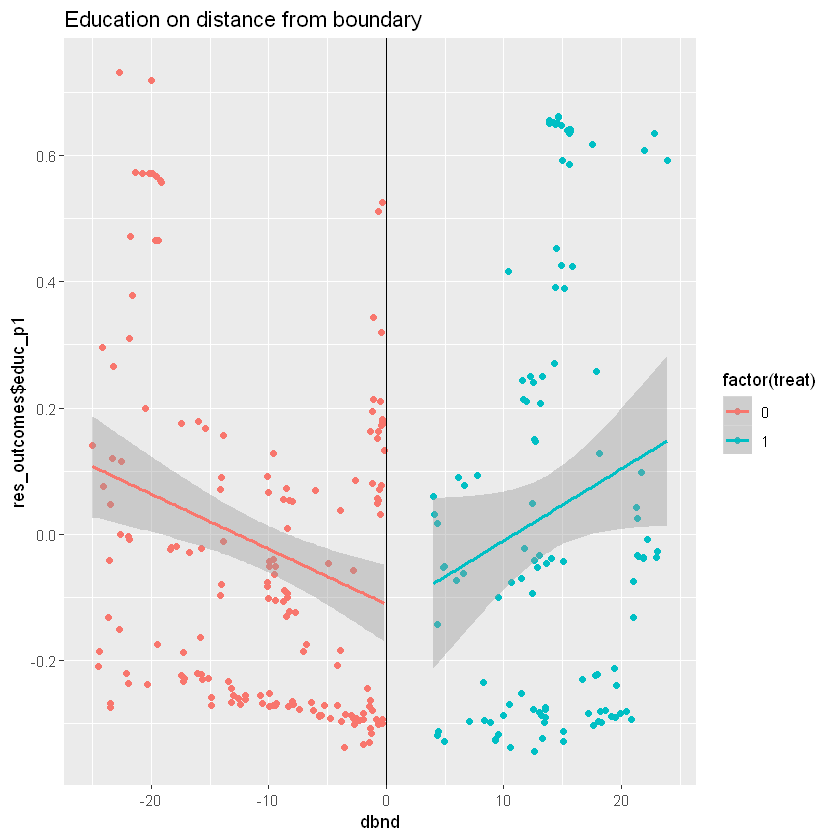

In [11]:
ggplot(ps3_data, aes(x = dbnd, y = res_outcomes$educ_p1, color=factor(treat)))+ 
  geom_point() +
  stat_smooth(method = lm) +
  geom_vline(xintercept = 0) +
  ggtitle("Education on distance from boundary")

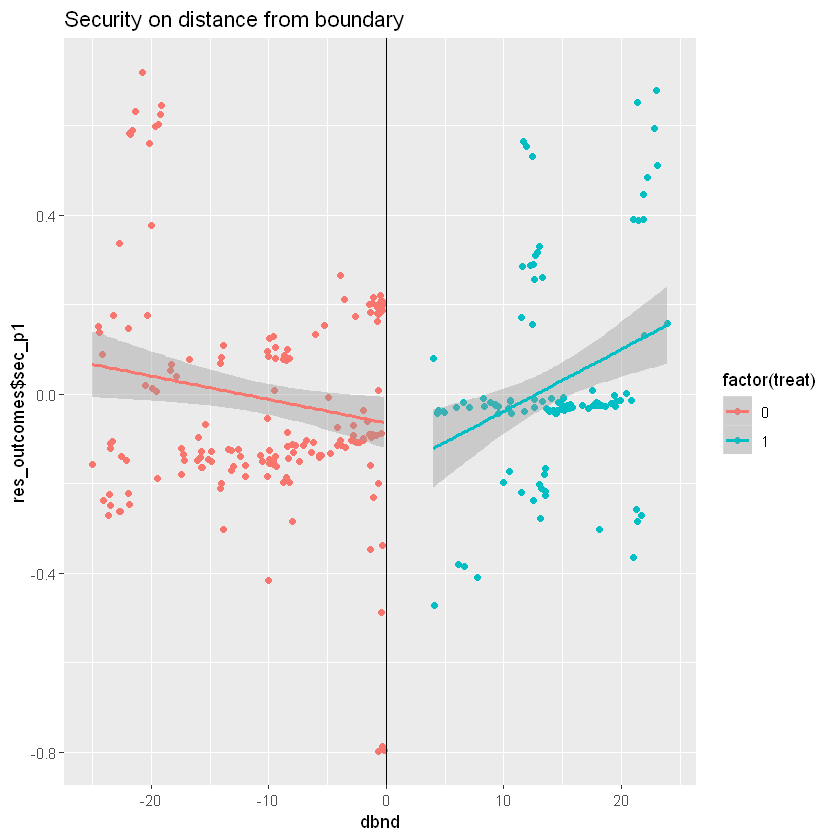

In [12]:
ggplot(ps3_data, aes(x = dbnd, y = res_outcomes$sec_p1, color=factor(treat)))+ 
  geom_point() +
  stat_smooth(method = lm) +
  geom_vline(xintercept = 0) +
  ggtitle("Security on distance from boundary")

### b) Now for the same 3 outcome variables repeat the analysis using a regression framework where being in the Marines regions is the treatment. Control for latitude, longitude, elevation, slope and the segment. Analyze when the distance to the discontinuity is 25 km or less and then when the distance is 10 km or less. Do you observe an effect of the hearts and minds approach for these outcomes? Discuss possible reasons for different results.

In [13]:
# Regressions in the region +- 25 km from discontinuity
regs25 = lapply(select(filter(ps3_data, dbnd<=25 & dbnd>= -25),health_p1, educ_p1, sec_p1), function(x) lm(x~ treat+lat + lon + elev+ slope+ seg2, data=filter(ps3_data, dbnd<=25 & dbnd>= -25)))
res_table25 = data.frame(t(sapply(regs25, function(x) coeftest(x)[c(2,9,16, 23)])))
colnames(res_table25) = c("US Marine Corps region coef",  "Std. Error", "t value",  "Pr(>|t|)")
res_table25

,US Marine Corps region coef,Std. Error,t value,Pr(>|t|)
health_p1,0.4490058,0.07933940,5.659304,3.598750e-08
educ_p1,0.2130107,0.06719663,3.169961,1.684885e-03
sec_p1,0.1026227,0.05429181,1.890206,5.971047e-02


In [14]:
# Regressions in the region +- 10 km from discontinuity
regs10 = lapply(select(filter(ps3_data, dbnd<=10 & dbnd>= -10),health_p1 , educ_p1, sec_p1), function(x) lm(x~ treat+lat + lon + elev+ slope+ seg2, data=filter(ps3_data, dbnd<=10 & dbnd>= -10)))
res_table10 = data.frame(t(sapply(regs10, function(x) coeftest(x)[c(2,9,16 ,23)])))
colnames(res_table10) = c("US Marine Corps region coef",  "Std. Error", "t value",  "Pr(>|t|)")
res_table10

,US Marine Corps region coef,Std. Error,t value,Pr(>|t|)
health_p1,0.4136621971,0.11811434,3.502218297,0.0006406133
educ_p1,0.1566087067,0.07383041,2.121195094,0.0358802668
sec_p1,0.0008421143,0.09325766,0.009029974,0.9928096171


We observe that health and education in the regions controled by the USMC, when we consider a caliper of 25 km., are 44.9% and 21.3% higher compare with the regions uner Army control; however, security does not have a significant effect.
When we consider a 10 km. caliper, there are no segnificant differences.